<a href="https://colab.research.google.com/github/UnknwonD/project_ai/blob/preprocessing/project_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
import json
from PIL import Image
from tqdm import notebook, tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data 압축 풀기

In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob

In [ ]:
# %cd /content/drive/MyDrive/project_ai

# !unzip -qq "/content/drive/MyDrive/project_ai/VL_damage_part.zip"

/content/drive/MyDrive/project_ai


In [ ]:
# %cd /content/drive/MyDrive/project_ai

# !unzip -qq "/content/drive/MyDrive/project_ai/VS_damage_part_jpg.zip"

/content/drive/MyDrive/project_ai
replace damage_part_jpg/0000016_as-0031772.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
filepaths1 = list(glob('/content/drive/MyDrive/project_ai/damage_part_json/*.json'))
print("json 파일 갯수 : {}".format(len(filepaths1)))

json 파일 갯수 : 17248


In [ ]:
filepaths2 = list(glob('/content/drive/MyDrive/project_ai/damage_part_jpg/*.jpg'))
print("jpg 파일 갯수 : {}".format(len(filepaths2)))

jpg 파일 갯수 : 17248


In [ ]:
filepaths3 = list(glob('/content/drive/MyDrive/project_ai/masked/*.jpg'))
print("mask 파일 갯수 : {}".format(len(filepaths3)))

mask 파일 갯수 : 17248


# 마스크 이미지 만들기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import os
import json
from PIL import Image
from tqdm import notebook, tqdm

In [11]:
# 이미지 파일 리사이즈 하는 함수 (원본이미지파일 경로, mask이미지인가[폴더구분위함], 가로세로 크기)
def resize_jpg(url, mask=False, w=512):
  save_path = '/content/drive/MyDrive/project_ai/dataset/'  # 저장할 이미지 경로

  # 저장할 경로 없으면 생성
  if not os.path.exists(save_path):
      os.mkdir(save_path)
      
  # 원본 이미지 경로의 모든 이미지 list 지정
  if not mask:
    data_list = os.listdir(url + "damage_part_jpg/")
  else:
    data_list = os.listdir(url + "masked/")
  
  print(len(data_list))
  
  if not os.path.exists(save_path + "x/"):
      os.mkdir(save_path + "x/")
  if not os.path.exists(save_path + "y/"):
      os.mkdir(save_path + "y/")

  # 모든 이미지 resize 후 저장하기
  for token in tqdm(data_list):
      # 이미지 열기
      if not mask:
        im = Image.open(url + "damage_part_jpg/" + token).convert('L').resize((w, w))
        im.save(save_path + "x/"+ token)
      else:
        im = Image.open(url + "masked/" + token).convert('L').resize((w, w))
        im.save(save_path + "y/"+ token)


# 파일 이름 리스트로 저장하는 함수
def extract_file_name(url):
  file_list = os.listdir(url)
  file_name = []
  for file in file_list:
    file_name.append(file.split('.')[0])
  return file_name

In [ ]:
# # 아예 세그멘테이션이 없는지 확인해볼게게
# files = tqdm(extract_file_name("/content/drive/MyDrive/project_ai/damage_part_jpg/"))

# for file in files:
#   with open('/content/drive/MyDrive/project_ai/damage_part_json/{}.json'.format(file), 'r') as f:
#     json_data = json.load(f)
#     mask_num = 0
#     for j in range(len(json_data["annotations"])):
#       if json_data["annotations"][j]["damage"] == None:
#         mask_num += 1
    
#     if len(json_data["annotations"]) == mask_num:
#       print("아무것도 없음")

In [ ]:
files = tqdm(extract_file_name("/content/drive/MyDrive/project_ai/damage_part_jpg"))

# 마스크 이미지를 저장할 경로 생성
save_path = '/content/drive/MyDrive/project_ai/masked/'
# save_path 경로가 없으면 폴더를 만듦
if not os.path.exists(save_path):
  os.mkdir(save_path)

for file in files:
  files.set_description(f"Processing {file}")
  imgfile = "/content/drive/MyDrive/project_ai/damage_part_jpg/{}.jpg".format(file)
  img = cv2.imread(imgfile)
  with open('/content/drive/MyDrive/project_ai/damage_part_json/{}.json'.format(file), 'r') as f:
    json_data = json.load(f)
  
  
  # 데미지 파트가 없다면 mask_num += 1
  mask_num = 0
  for j in range(len(json_data["annotations"])):
    if json_data["annotations"][j]["damage"] == None:
      mask_num += 1


  img[img!=256] = 0

  ## mask_num을 뺀 segmentation 정보까지만 사용하여 마스크 이미지 만들기
  # segmentation 없으면 바로 저장
  if len(json_data["annotations"]) == mask_num:
    # 마스크된 이미지는 이미지파일이름+mask 파일로 save_path 경로에 저장
    cv2.imwrite("/content/drive/MyDrive/project_ai/masked/{}_mask.jpg".format(file), img)
  
  # 있으면 파손 부위 라벨링링
  else:
    for i in range(len(json_data["annotations"])-mask_num):
      area = np.array(json_data["annotations"][i]["segmentation"][0][0])
      filled = cv2.fillPoly(img, pts = [area], color = (255, 255, 255))
      # 마스크된 이미지는 이미지파일이름+mask 파일로 save_path 경로에 저장
      cv2.imwrite("/content/drive/MyDrive/project_ai/masked/{}_mask.jpg".format(file), filled)

Processing 0008088_as-0010329: 100%|██████████| 17248/17248 [25:35<00:00, 11.23it/s]


리사이즈하기

In [ ]:
resize_jpg("/content/drive/MyDrive/project_ai/", mask=False, w=500)

17248


100%|██████████| 17248/17248 [13:23<00:00, 21.47it/s]


In [ ]:
resize_jpg("/content/drive/MyDrive/project_ai/", mask=True, w=500)

17248


100%|██████████| 17248/17248 [08:18<00:00, 34.58it/s]


In [ ]:
from glob import glob

filepaths4 = list(glob('/content/drive/MyDrive/project_ai/dataset/x/*.jpg'))
filepaths5 = list(glob('/content/drive/MyDrive/project_ai/dataset/y/*.jpg'))
print("dataset-x 파일 갯수 : {}".format(len(filepaths4)))
print("dataset-y 파일 갯수 : {}".format(len(filepaths5)))

dataset-x 파일 갯수 : 17248
dataset-y 파일 갯수 : 17248


# 사용할 데이터(이미지) 정리



In [21]:
from sklearn.model_selection import train_test_split
from glob import glob
import tqdm
import matplotlib.pyplot as plt

In [12]:
## 데이터 불러오기
dir_data = '/content/drive/MyDrive/project_ai' 

# 원본 이미지 (리사이즈 된)
path_dir_x = '/content/drive/MyDrive/project_ai/dataset/x/'
# 마스크 이미지 (리사이즈 된)
path_dir_y = '/content/drive/MyDrive/project_ai/dataset/y/'

imgs = extract_file_name("/content/drive/MyDrive/project_ai/dataset/x/")

nframe = len(imgs)

# 파일 이름이 들어있음. 8:1:1
train_names, test_names = train_test_split(imgs, test_size = 0.2, random_state=910, shuffle=True)
val_names, test_names = train_test_split(test_names, test_size = 0.5, random_state=910, shuffle=True)

dir_save_train = os.path.join(dir_data, 'train')
dir_save_val = os.path.join(dir_data, 'val')
dir_save_test = os.path.join(dir_data, 'test')

if not os.path.exists(dir_save_train):
    os.makedirs(dir_save_train)
    os.makedirs(dir_save_val)
    os.makedirs(dir_save_test)

id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

In [13]:
print(train_names[1])

0599735_as-0040967


In [17]:
## 선택된 train 이미지를 npy 파일로 저장
for i in tqdm(range(len(train_names))):
  file_x = train_names[i]
  img_input = Image.open(path_dir_x + file_x + ".jpg")
  img_label = Image.open(path_dir_y + file_x + "_mask.jpg")

  input_ = np.asarray(img_input)
  label_ = np.asarray(img_label)
  
  np.save(os.path.join(dir_save_train, 'input_%05d.npy' % i), input_)
  np.save(os.path.join(dir_save_train, 'label_%05d.npy' % i), label_)

100%|██████████| 13798/13798 [1:03:01<00:00,  3.65it/s]


In [18]:
## 선택된 val 이미지를 npy 파일로 저장
for i in tqdm(range(len(val_names))):
  file_x = val_names[i]
  img_input = Image.open(path_dir_x + file_x + ".jpg")
  img_label = Image.open(path_dir_y + file_x + "_mask.jpg")

  input_ = np.asarray(img_input)
  label_ = np.asarray(img_label)
  
  np.save(os.path.join(dir_save_val, 'input_%05d.npy' % i), input_)
  np.save(os.path.join(dir_save_val, 'label_%05d.npy' % i), label_)

100%|██████████| 1725/1725 [10:56<00:00,  2.63it/s]


In [19]:
## 선택된 test 이미지를 npy 파일로 저장
for i in tqdm(range(len(test_names))):
  file_x = test_names[i]
  img_input = Image.open(path_dir_x + file_x + ".jpg")
  img_label = Image.open(path_dir_y + file_x + "_mask.jpg")

  input_ = np.asarray(img_input)
  label_ = np.asarray(img_label)
  
  np.save(os.path.join(dir_save_test, 'input_%05d.npy' % i), input_)
  np.save(os.path.join(dir_save_test, 'label_%05d.npy' % i), label_)

100%|██████████| 1725/1725 [10:49<00:00,  2.66it/s]


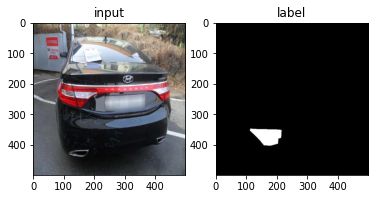

In [22]:
## 이미지 시각화

plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.show()

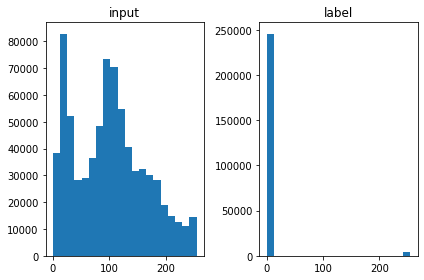

In [23]:
## 한 이미지의 분포

plt.subplot(122)
plt.hist(label_.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input_.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

# U-Net 네트워크 구축


In [ ]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

In [ ]:
## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)
    
    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

# DataLoader

In [ ]:
# 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))

        # 정규화
        label = label/255.0
        input = input/255.0

        # 이미지와 레이블의 차원 = 2일 경우(채널이 없을 경우, 흑백 이미지), 새로운 채널(축) 생성
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
            # label = np.repeat(label[:,:,np.newaxis],3,-1) # 세 번째 차원의 수가 3개 (컬러를 말함)
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input': input, 'label': label}

        # transform이 정의되어 있다면 transform을 거친 데이터를 불러옴
        if self.transform:
            data = self.transform(data)

        return data

In [ ]:
## 데이터 Shape 확인해보기

print("X 이미지 Shape : {}".format(input_.shape))
print("Y 이미지 Shape : {}".format(label_.shape))

In [ ]:
## 데이터로더 잘 구현되었는지 확인

dataset_train = Dataset(data_dir=dir_save_train)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

In [ ]:
# 불러온 이미지 시각화

plt.subplot(122)
plt.imshow(label.reshape(754, 1508, 3), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(754, 1508, 3), cmap='gray')
plt.title('input')

plt.show()

# Transform

In [ ]:
# 트렌스폼 구현하기
class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # 배열 순서 바꿈 픽셀컬러 정보를 맨 앞으로
        label = label.transpose((2, 0, 1)).astype(np.float32)
        input = input.transpose((2, 0, 1)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

## 정규화
class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data

class RandomFlip(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        if np.random.rand() > 0.5:
            label = np.fliplr(label)
            input = np.fliplr(input)

        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

In [ ]:
## 트랜스폼 잘 구현되었는지 확인
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

In [ ]:
## 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

# Network 저장 & 호출

In [ ]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

In [ ]:
## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

# Network 훈련

In [ ]:
# 훈련 파라미터 설정하기
lr = 1e-3
batch_size = 4
num_epoch = 20

base_dir = './drive/MyDrive/DACrew/unet'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")


# 훈련을 위한 Transform과 DataLoader
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

# 네트워크 생성하기
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = UNet().to(device)

# 손실함수 정의하기
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

# 네트워크 학습시키기
st_epoch = 0

# 학습한 모델이 있을 경우 모델 로드하기
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim) 

for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optim.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optim.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
            writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

        writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

        with torch.no_grad():
            net.eval()
            loss_arr = []

            for batch, data in enumerate(loader_val, 1):
                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                output = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

                # Tensorboard 저장하기
                label = fn_tonumpy(label)
                input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
                output = fn_tonumpy(fn_class(output))

                writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
                writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

        writer_val.add_scalar('loss', np.mean(loss_arr), epoch)

        # epoch 50마다 모델 저장하기
        if epoch % 50 == 0:
            save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

        writer_train.close()
        writer_val.close()

# Model Test

In [ ]:
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / batch_size)

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)

          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

# Result Visualization

In [ ]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()